# Twitter Sentiment Analysis for Stock Investment


**Claire Zhao Sun**
- Matrikelnummer: 3630998
- Msc. Scientific Computing, Heidelberg University
- pz237@stud.uni-heidelberg.de

**Last Modified: 2021.02.01**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# Set dataframe display options - displaying all contents in all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

from IPython.display import Markdown

## 1. Load and Preprocess Training Data

In [2]:
from modules.preprocessing_SUN import tweet_preprocessing, tweet_tokenizing, display_stats
import ast # bytes to string
from sklearn.model_selection import train_test_split

C:\Users\clair\Desktop\WS2020\NLP\Project\modules\preprocessing_SUN.py:36: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dict_emoticon = pd.read_csv('./modules/emoticons.csv', header='infer', delimiter='\t', index_col=0).T.to_dict()
C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
# Load training data with raw tweets 
df = pd.read_csv('data/Twitter_Training_all.csv',na_filter=False)
df.drop_duplicates(inplace=True)
df['text_unicode'] = df['text'].apply(lambda x:ast.literal_eval(x).decode('utf-8'))

# Apply preprocessing (default: no stop words removal, no spelling correction)
df['text_clean'] = df['text_unicode'].apply(tweet_preprocessing)
df['token_counts'] = df['text_clean'].apply(tweet_tokenizing).apply(len)

# Convert sentiment label to int
sentiment_to_label = {'negative':0, 'neutral': 1, 'positive':2}
sentiments = ['negative', 'neutral', 'positive']
df['label'] = df['sentiment'].apply(lambda x: sentiment_to_label[x]).astype(int)

# Split dataset into training (80%), validation (10%) and test set(10%) by stratification to deal with class imbalance
df_train, df_ = train_test_split(df,test_size = 0.2, stratify=df['sentiment'], shuffle = True, random_state=100) 
df_test, df_valid = train_test_split(df_,test_size = 0.5, stratify=df_['sentiment'], shuffle = True, random_state=100) 

# Save training data for future reproducible use
df_train.to_csv('data/Twitter_train.csv',index=False)
df_valid.to_csv('data/Twitter_valid.csv',index=False)
df_test.to_csv('data/Twitter_test.csv',index=False)

# Display samples
df_train.head(5)

,id,text,sentiment,text_unicode,text_clean,token_counts,label
21763,264180884566069248,"b""I'm getting off work tomorrow. Then coming home to watch the Heat win and talk shit.""",positive,I'm getting off work tomorrow. Then coming home to watch the Heat win and talk shit.,Im getting off work tomorrow Then coming home to watch the Heat win and talk shit,16,2
18572,96619333626769408,b'RT @StevenTDennis: Today *very* rare day when Democrats will get healthier on their Club for Growth scorecards than most Republicans.',positive,RT @StevenTDennis: Today *very* rare day when Democrats will get healthier on their Club for Growth scorecards than most Republicans.,RT USERNAME Today very rare day when Democrats will get healthier on their Club for Growth scorecards than most Republicans,20,2
21389,264130222163640320,b'#SEC on @SDS - Is the SEC behind Alabama this Saturday night? http://t.co/QPN7LKEe',neutral,#SEC on @SDS - Is the SEC behind Alabama this Saturday night? http://t.co/QPN7LKEe,second on USERNAME Is the second behind Alabama this Saturday night,11,1
17808,258221308767256577,b'The Clown has broken the record and become the 1st film to win 12 Brazilian Academy Awards yesterday. http://t.co/mbSGY3kt',neutral,The Clown has broken the record and become the 1st film to win 12 Brazilian Academy Awards yesterday. http://t.co/mbSGY3kt,The Clown has broken the record and become the first film to win 12 Brazilian Academy Awards yesterday,18,1
14744,263718726627627009,"b""@heeydems Do you know ?they may not but we're so fond of all the countries . Uh,happy Republic Day .""",positive,"@heeydems Do you know ?they may not but we're so fond of all the countries . Uh,happy Republic Day .",USERNAME Do you know they may not but were so fond of all the countries Uhhappy Republic Day,18,2


#### Exploratory Data Analysis on Training Dataset

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


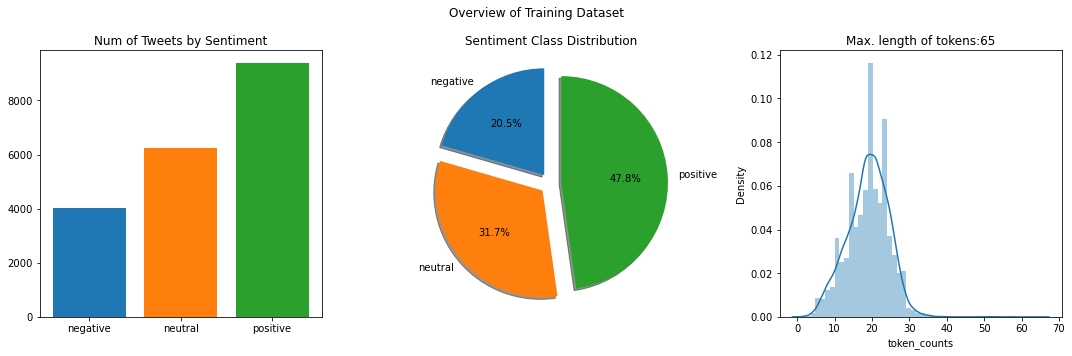

In [6]:
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout=True)
fig.suptitle('Overview of Training Dataset')

data = np.unique(df.sentiment, return_counts=True)[1]
class_names = np.unique(df.sentiment, return_counts=True)[0]

ax[0].set_title("Num of Tweets by Sentiment")
ax[0].bar([0,1,2], data, tick_label=sentiments, color=['C0','C1','C2']);

ax[1].set_title("Sentiment Class Distribution")
ax[1].pie(data, labels= sentiments, autopct='%1.1f%%',shadow=True, startangle=90,explode=(0.1,0.1, 0.1))

ax[2].set_xlabel('Token count')
ax[2] = sns.distplot(df['token_counts'])
ax[2].set_title(f"Max. length of tokens:{df['token_counts'].max()}");



***Oberservations:***
- *The training dataset is imbalanced in its class distribution - need to perform SMOTE (Synthetic Minority Oversampling Technique)*


# 

## 2. Lexicon and Rule-based Methods

In [8]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
VaderAnalyzer = SentimentIntensityAnalyzer()

df['score_Vader'] = df['text_clean'].apply(lambda x: VaderAnalyzer.polarity_scores(x)['compound'])
# Compound score value range to corresponding sentiments https://github.com/cjhutto/vaderSentiment
df['Vader']=df['score_Vader'].apply(lambda x : 'negative' if x < -0.05 else ('positive' if x > 0.05 else 'neutral'))

df['score_TextBlob'] = df['text_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['TextBlob']=df['score_TextBlob'].apply(lambda x : 'negative' if x < -0.05 else ('positive' if x > 0.05 else 'neutral'))

print('Sentiment Classification by Vader:\n', classification_report(df.sentiment,df.Vader))
print('Sentiment Classification by TextBlob:\n', classification_report(df.sentiment,df.TextBlob))

Sentiment Classification by Vader:
               precision    recall  f1-score   support

    negative       0.48      0.49      0.49      4033
     neutral       0.50      0.39      0.44      6232
    positive       0.64      0.73      0.68      9388

    accuracy                           0.57     19653
   macro avg       0.54      0.54      0.53     19653
weighted avg       0.56      0.57      0.56     19653

Sentiment Classification by TextBlob:
               precision    recall  f1-score   support

    negative       0.40      0.33      0.36      4033
     neutral       0.42      0.45      0.43      6232
    positive       0.63      0.64      0.64      9388

    accuracy                           0.52     19653
   macro avg       0.48      0.48      0.48     19653
weighted avg       0.52      0.52      0.52     19653



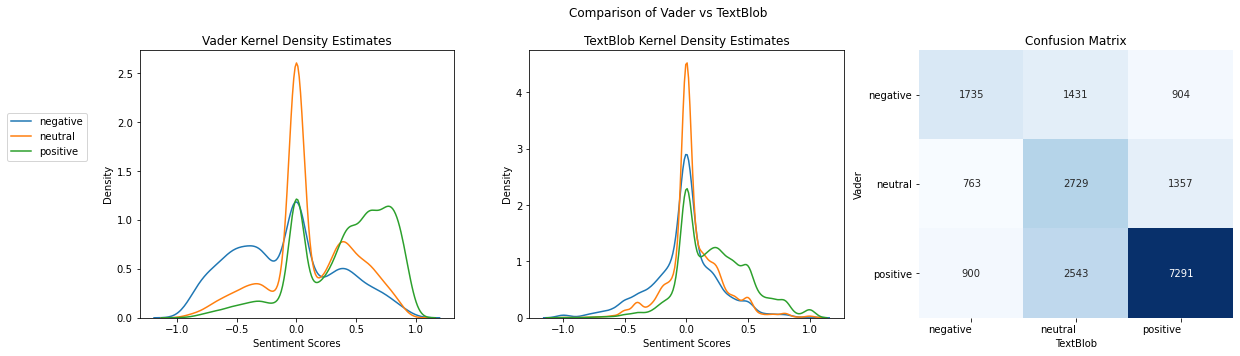

In [9]:
fig, ax = plt.subplots(1,3,figsize=(16,5),tight_layout=True)
fig.suptitle('Comparison of Vader vs TextBlob')

ax[0].set_title('Vader Kernel Density Estimates')
ax[1].set_title('TextBlob Kernel Density Estimates')

for i in range(3):
    sns.kdeplot(x=df[df.sentiment==sentiments[i]]['score_Vader'],ax=ax[0], label=sentiments[i],legend=True)
    sns.kdeplot(x=df[df.sentiment==sentiments[i]]['score_TextBlob'],ax=ax[1])
fig.legend(bbox_to_anchor=(0, 0.7))
ax[0].set_xlabel('Sentiment Scores')
ax[1].set_xlabel('Sentiment Scores')


ax[2].set_title('Confusion Matrix')
cm = confusion_matrix(df['Vader'],df['TextBlob'])
hmap = sns.heatmap(cm, annot=True, fmt='d',ax=ax[2], cmap="Blues",cbar=False)
hmap.yaxis.set_ticklabels(sentiments, rotation=0, ha='right')
hmap.xaxis.set_ticklabels(sentiments, rotation=0, ha='right')
hmap.set_ylabel('Vader')
hmap.set_xlabel('TextBlob');


***Oberservations:***
- *Sentiment classification by Lexicon-based TextBlob performed poorly with only macro F1 score at only 46%, whereas rule-based Vader performed slightly better at 52%.*  
- *From the Kernel Density Estimates, we can see that sentiment scores obtained from both methods are not immediately separable according to sentiment class labels, i.e. peaks around 0 for all three classes*
- *We will include Vader in our ensemble model while rejecting TextBlob due to inadequate performance*


In [10]:
def apply_Vader(df):
    df['Vader_score'] = df['text_clean'].apply(lambda x: VaderAnalyzer.polarity_scores(x)['compound'])
    df['Vader_sentiment'] = df['Vader_score'].apply(lambda x : 'negative' if x < -0.05 else ('positive' if x > 0.05 else 'neutral'))
    df['Vader_label'] = df['Vader_sentiment'].apply(lambda x: sentiment_to_label[x]).astype(int)
    return df

apply_Vader(df_train).to_csv('data/Twitter_train.csv',index=False)
apply_Vader(df_valid).to_csv('data/Twitter_valid.csv',index=False)
apply_Vader(df_test).to_csv('data/Twitter_test.csv',index=False)

df_train.columns,df_valid.columns,df_test.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

(Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
        'label', 'Vader_score', 'Vader_sentiment', 'Vader_label'],
       dtype='object'),
 Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
        'label', 'Vader_score', 'Vader_sentiment', 'Vader_label'],
       dtype='object'),
 Index(['id', 'text', 'sentiment', 'text_unicode', 'text_clean', 'token_counts',
        'label', 'Vader_score', 'Vader_sentiment', 'Vader_label'],
       dtype='object'))

# 
## 3. ML-based Methods: NB, Logistic Regression and SVM

In [11]:
from modules.ML_classifiers_SUN import WordEmbeddingVectorizer,vectorize,train_classifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

import importlib
import sys
importlib.reload(sys.modules['modules.ML_classifiers_SUN'])


<module 'modules.ML_classifiers_SUN' from 'C:\\Users\\clair\\Desktop\\WS2020\\NLP\\Project\\modules\\ML_classifiers_SUN.py'>

In [12]:
# Set up training data 
corpus = df_train['text_clean'].to_list()

x_train = df_train['text_clean']
y_train = df_train['sentiment']

x_valid = df_valid['text_clean']
y_valid = df_valid['sentiment']


In [20]:
def plot_f1(vectorizer,classifiers,mode): 
    
    cols = len(classifiers)        
    fig,ax = plt.subplots(1,cols, tight_layout=True,sharex=True,sharey=True,figsize=(15,5))
    fig.suptitle(vectorizer+'_'+mode)
    
    for j in range(cols):
        report_name = 'models/'+vectorizer+'_'+classifiers[j]+'_'+mode+'_report.csv'
        df_report = pd.read_csv(report_name)
        data_bar = df_report[df_report['report']=='valid'].iloc[[0,1,2],[0,3]]
        data_line = df_report[df_report['report']=='valid'].iloc[[4]]['f1-score'].values.item()
        ax[j].set_title(classifiers[j])
        ax[j].set_ylabel('f1-score')
        x = ax[j].bar(['negative','neutral','positive'],data_bar['f1-score'])
        x[0].set_color('C0')
        x[1].set_color('C1')
        x[2].set_color('C2')
        ax[j].axhline(data_line,color='C3', linestyle='dashed')
        ax[j].annotate(f"Macro Avg: {data_line:.3}",(-0.3,data_line+.05))
        ax[j].set_ylim(0,1)
        

### CountVectorizer

In [13]:
# Initialize vectorizers
vectorizer = CountVectorizer(analyzer='word', min_df = 3, ngram_range = (1,1)) 
start_time = time.time()

# Fit vectorizer on corpus
vectorizer.fit(corpus)
train_time = time.time()

# Data vectorization
x_train_vect = vectorizer.transform(x_train).toarray()
x_valid_vect = vectorizer.transform(x_valid).toarray()
transform_time = time.time()

# Data resampling to adjust for class imbalance
smote = SMOTE()
x_train_res, y_train_res = smote.fit_sample(x_train_vect, y_train)
resample_time = time.time()

print(f"vectorizer_fitting: {train_time - start_time: .2f}s")
print(f"data_vectorization: {transform_time - train_time: .2f}s")
print(f"data_resampling: {resample_time - transform_time: .2f}s")

# Save vectorizer
with open('models/CountVectorizer_unigram.pickle','wb') as f:
    pickle.dump(vectorizer, f)


vectorizer_fitting:  0.24s
data_vectorization:  0.44s
data_resampling:  418.63s


***Oberservations:***
- *SMOTE resampling takes a long time.*

In [14]:
display(Markdown("**CountVectorizer_Unigram with Balanced Class Weight (No Resampling)**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Count_word_NB_balancedWeight.pickle'
report_save ='models/Count_word_NB_balancedWeight_report.csv' 
classifier = MultinomialNB(fit_prior=False)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Count_word_LR_balancedWeight.pickle'
report_save ='models/Count_word_LR_balancedWeight_report.csv' 
classifier = LogisticRegression(class_weight='balanced',max_iter=200)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Count_word_SVM_balancedWeight.pickle'
report_save ='models/Count_word_SVM_balancedWeight_report.csv' 
classifier = LinearSVC(class_weight='balanced',max_iter=200)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)



**CountVectorizer_Unigram with Balanced Class Weight (No Resampling) **

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.61      0.78      0.69      3226
     neutral       0.73      0.70      0.72      4986
    positive       0.83      0.75      0.79      7510

    accuracy                           0.74     15722
   macro avg       0.72      0.74      0.73     15722
weighted avg       0.75      0.74      0.74     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.58      0.52       404
     neutral       0.57      0.57      0.57       623
    positive       0.74      0.65      0.69       939

    accuracy                           0.61      1966
   macro avg       0.59      0.60      0.59      1966
weighted avg       0.63      0.61      0.62      1966

Time to train:  3.65s
Time to predict:  0.64s


*Logistic Regression*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.80      0.95      0.87      3226
     neutral       0.85      0.88      0.87      4986
    positive       0.93      0.84      0.89      7510

    accuracy                           0.88     15722
   macro avg       0.86      0.89      0.87     15722
weighted avg       0.88      0.88      0.88     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.53      0.49       404
     neutral       0.52      0.58      0.55       623
    positive       0.73      0.62      0.67       939

    accuracy                           0.59      1966
   macro avg       0.57      0.58      0.57      1966
weighted avg       0.60      0.59      0.59      1966

Time to train:  22.48s
Time to predict:  0.65s


*Support Vector Machine*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.89      0.96      0.92      3226
     neutral       0.93      0.92      0.92      4986
    positive       0.95      0.92      0.94      7510

    accuracy                           0.93     15722
   macro avg       0.92      0.93      0.93     15722
weighted avg       0.93      0.93      0.93     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.41      0.42      0.42       404
     neutral       0.49      0.52      0.51       623
    positive       0.67      0.64      0.65       939

    accuracy                           0.56      1966
   macro avg       0.52      0.53      0.53      1966
weighted avg       0.56      0.56      0.56      1966

Time to train:  1.55s
Time to predict:  0.61s


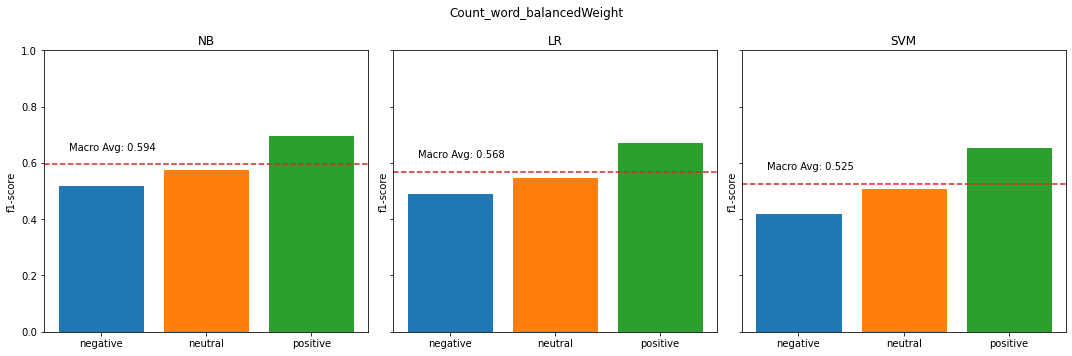

In [21]:
plot_f1(vectorizer='Count_word',classifiers=['NB','LR','SVM'],mode='balancedWeight')

**CountVectorizer_Unigram with SMOTE Resampling**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.72      0.76      0.74      7510
     neutral       0.71      0.69      0.70      7510
    positive       0.77      0.74      0.75      7510

    accuracy                           0.73     22530
   macro avg       0.73      0.73      0.73     22530
weighted avg       0.73      0.73      0.73     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.60      0.52       404
     neutral       0.55      0.56      0.56       623
    positive       0.74      0.64      0.68       939

    accuracy                           0.61      1966
   macro avg       0.58      0.60      0.59      1966
weighted avg       0.62      0.61      0.61      1966

Time to train:  5.03s
Time to predict:  0.83s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.78      0.87      0.82      7510
     neutral       0.83      0.74      0.78      7510
    positive       0.89      0.88      0.88      7510

    accuracy                           0.83     22530
   macro avg       0.83      0.83      0.83     22530
weighted avg       0.83      0.83      0.83     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.44      0.45      0.44       404
     neutral       0.52      0.57      0.54       623
    positive       0.70      0.65      0.67       939

    accuracy                           0.58      1966
   macro avg       0.55      0.56      0.55      1966
weighted avg       0.59      0.58      0.58      1966

Time to train:  48.42s
Time to predict:  0.88s


*Support Vector Machine*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.81      0.91      0.86      7510
     neutral       0.88      0.77      0.82      7510
    positive       0.93      0.93      0.93      7510

    accuracy                           0.87     22530
   macro avg       0.87      0.87      0.87     22530
weighted avg       0.87      0.87      0.87     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.41      0.44      0.43       404
     neutral       0.50      0.52      0.51       623
    positive       0.67      0.63      0.65       939

    accuracy                           0.55      1966
   macro avg       0.53      0.53      0.53      1966
weighted avg       0.56      0.55      0.56      1966

Time to train:  3.07s
Time to predict:  0.86s


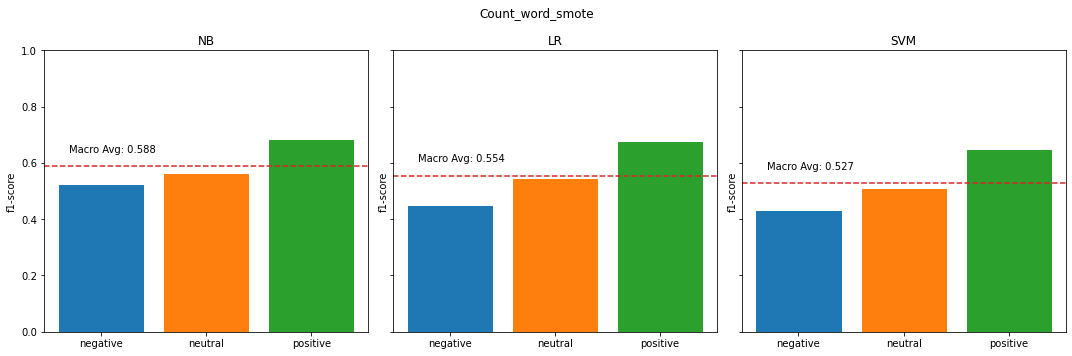

In [23]:
display(Markdown("**CountVectorizer_Unigram with SMOTE Resampling**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Count_word_NB_smote.pickle'
report_save ='models/Count_word_NB_smote_report.csv' 
classifier = MultinomialNB()
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Count_word_LR_smote.pickle'
report_save ='models/Count_word_LR_smote_report.csv' 
classifier = LogisticRegression(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Count_word_SVM_smote.pickle'
report_save ='models/Count_word_SVM_smote_report.csv' 
classifier = LinearSVC(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Count_word',classifiers=['NB','LR','SVM'],mode='smote')


**CountVectorizer_Unigram with Resampling and Data Normalisation**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.73      0.78      0.76      7510
     neutral       0.74      0.68      0.71      7510
    positive       0.76      0.76      0.76      7510

    accuracy                           0.74     22530
   macro avg       0.74      0.74      0.74     22530
weighted avg       0.74      0.74      0.74     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.60      0.52       404
     neutral       0.56      0.55      0.55       623
    positive       0.72      0.63      0.67       939

    accuracy                           0.60      1966
   macro avg       0.58      0.59      0.58      1966
weighted avg       0.62      0.60      0.60      1966

Time to train:  2.85s
Time to predict:  1.59s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.77      0.87      0.82      7510
     neutral       0.82      0.73      0.77      7510
    positive       0.88      0.87      0.87      7510

    accuracy                           0.82     22530
   macro avg       0.82      0.82      0.82     22530
weighted avg       0.82      0.82      0.82     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.45      0.45      0.45       404
     neutral       0.52      0.56      0.54       623
    positive       0.69      0.66      0.68       939

    accuracy                           0.58      1966
   macro avg       0.55      0.56      0.56      1966
weighted avg       0.59      0.58      0.59      1966

Time to train:  33.85s
Time to predict:  1.66s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.80      0.91      0.85      7510
     neutral       0.88      0.76      0.82      7510
    positive       0.92      0.93      0.92      7510

    accuracy                           0.87     22530
   macro avg       0.87      0.87      0.86     22530
weighted avg       0.87      0.87      0.86     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.41      0.45      0.43       404
     neutral       0.49      0.52      0.50       623
    positive       0.67      0.63      0.65       939

    accuracy                           0.56      1966
   macro avg       0.53      0.53      0.53      1966
weighted avg       0.56      0.56      0.56      1966

Time to train:  4.07s
Time to predict:  1.59s


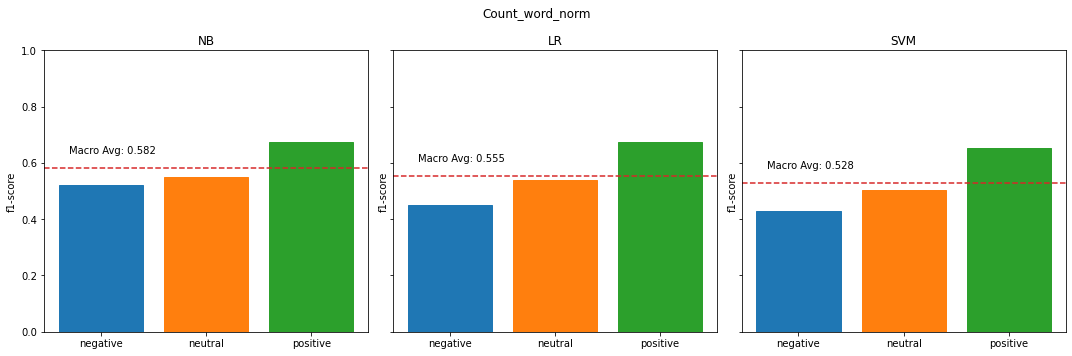

In [24]:
display(Markdown("**CountVectorizer_Unigram with Resampling and Data Normalisation**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Count_word_NB_norm.pickle'
report_save ='models/Count_word_NB_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB())
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Count_word_LR_norm.pickle'
report_save ='models/Count_word_LR_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Count_word_SVM_norm.pickle'
report_save ='models/Count_word_SVM_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), LinearSVC(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Count_word',classifiers=['NB','LR','SVM'],mode='norm')


**CountVectorizer_Unigram with Resampling and Data Standardization**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.73      0.78      0.76      7510
     neutral       0.74      0.68      0.71      7510
    positive       0.76      0.76      0.76      7510

    accuracy                           0.74     22530
   macro avg       0.74      0.74      0.74     22530
weighted avg       0.74      0.74      0.74     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.60      0.52       404
     neutral       0.56      0.55      0.55       623
    positive       0.72      0.63      0.67       939

    accuracy                           0.60      1966
   macro avg       0.58      0.59      0.58      1966
weighted avg       0.62      0.60      0.60      1966

Time to train:  2.70s
Time to predict:  1.55s


*Logistic Regression*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.87      0.93      0.90      7510
     neutral       0.93      0.88      0.91      7510
    positive       0.98      0.98      0.98      7510

    accuracy                           0.93     22530
   macro avg       0.93      0.93      0.93     22530
weighted avg       0.93      0.93      0.93     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.34      0.38      0.36       404
     neutral       0.45      0.47      0.46       623
    positive       0.62      0.57      0.59       939

    accuracy                           0.50      1966
   macro avg       0.47      0.47      0.47      1966
weighted avg       0.51      0.50      0.50      1966

Time to train:  79.16s
Time to predict:  1.86s


*Support Vector Machine*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.86      0.92      0.89      7510
     neutral       0.91      0.85      0.88      7510
    positive       0.96      0.96      0.96      7510

    accuracy                           0.91     22530
   macro avg       0.91      0.91      0.91     22530
weighted avg       0.91      0.91      0.91     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.31      0.35      0.33       404
     neutral       0.42      0.45      0.43       623
    positive       0.60      0.55      0.57       939

    accuracy                           0.47      1966
   macro avg       0.45      0.45      0.45      1966
weighted avg       0.49      0.47      0.48      1966

Time to train:  315.02s
Time to predict:  1.61s


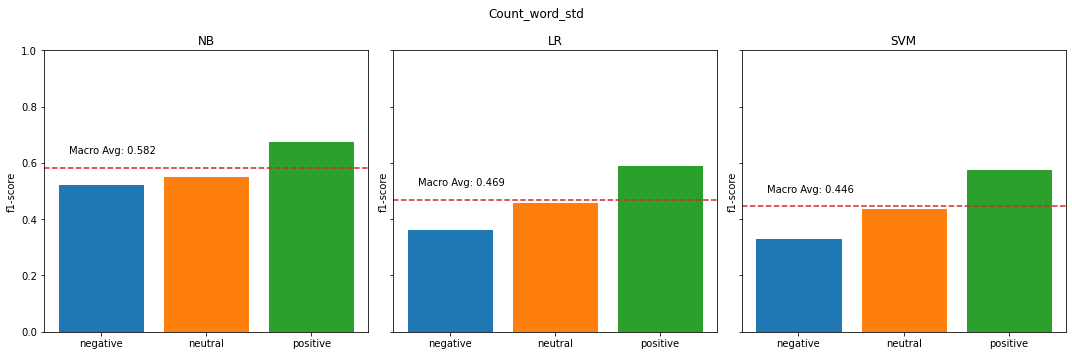

In [26]:
display(Markdown("**CountVectorizer_Unigram with Resampling and Data Standardization**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Count_word_NB_std.pickle'
report_save ='models/Count_word_NB_std_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB())
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Count_word_LR_std.pickle'
report_save ='models/Count_word_LR_std_report.csv' 
classifier = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Count_word_SVM_std.pickle'
report_save ='models/Count_word_SVM_std_report.csv' 
classifier = make_pipeline(StandardScaler(), LinearSVC(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Count_word',classifiers=['NB','LR','SVM'],mode='std')


***Oberservations:***

- *NB consistently outperforming LR and SVM for word count vectorization with 3-6%*
- *Best macro f1 score at 59% for NB using balanced class weight rather than SMOTE resampling*
- *Normalizing data before training does not offer obvious benefit for all three classifiers*  
- *Data standardization makes classifiers LR and SVM underperform by c. 7-8% vs no standardization; it also takes much longer to train classifiers with standardized data* 
- *For LR and SVM, increase max_iter=500 for convergence* 
- *Generally NB takes less time to train than LR and SVM*


<font color=blue> **Preliminary Conclusion:** </font>

<font color=blue> - Overall in terms of macro-F1 score, NB (59%) performs best with unigram CountVectorizer (i.e. bag-of-words count).</font>


# 


### TfidfVectorizer

In [27]:
# TfidfVectorizer_unigram
vectorizer = TfidfVectorizer(analyzer='word', min_df = 3, ngram_range = (1,1))  # initiate vectorizer
start_time = time.time()

# Fit vectorizer on corpus
vectorizer.fit(corpus)
train_time = time.time()

# Data vectorization
x_train_vect = vectorizer.transform(x_train).toarray()
x_valid_vect = vectorizer.transform(x_valid).toarray()
transform_time = time.time()

# Data resampling to adjust for class imbalance
smote = SMOTE()
x_train_res, y_train_res = smote.fit_sample(x_train_vect, y_train)
resample_time = time.time()

print(f"vectorizer_fitting: {train_time - start_time: .2f}s")
print(f"data_vectorization: {transform_time - train_time: .2f}s")
print(f"data_resampling: {resample_time - transform_time: .2f}s")

# Save vectorizer
with open('models/TfidfVectorizer_unigram.pickle','wb') as f:
    pickle.dump(vectorizer, f)


vectorizer_fitting:  0.27s
data_vectorization:  0.55s
data_resampling:  425.92s


**TfidfVectorizer_Unigram with Balanced Class Weight (No Resampling)**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.68      0.70      0.69      3226
     neutral       0.76      0.68      0.72      4986
    positive       0.78      0.82      0.80      7510

    accuracy                           0.75     15722
   macro avg       0.74      0.73      0.74     15722
weighted avg       0.75      0.75      0.75     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.49      0.49      0.49       404
     neutral       0.57      0.53      0.55       623
    positive       0.69      0.72      0.71       939

    accuracy                           0.61      1966
   macro avg       0.59      0.58      0.58      1966
weighted avg       0.61      0.61      0.61      1966

Time to train:  0.31s
Time to predict:  0.21s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.67      0.87      0.75      3226
     neutral       0.74      0.79      0.76      4986
    positive       0.89      0.74      0.81      7510

    accuracy                           0.78     15722
   macro avg       0.77      0.80      0.77     15722
weighted avg       0.80      0.78      0.78     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.48      0.60      0.53       404
     neutral       0.54      0.63      0.58       623
    positive       0.77      0.60      0.68       939

    accuracy                           0.61      1966
   macro avg       0.60      0.61      0.60      1966
weighted avg       0.64      0.61      0.62      1966

Time to train:  17.15s
Time to predict:  0.20s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.82      0.90      0.86      3226
     neutral       0.87      0.85      0.86      4986
    positive       0.91      0.88      0.89      7510

    accuracy                           0.88     15722
   macro avg       0.86      0.88      0.87     15722
weighted avg       0.88      0.88      0.88     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.48      0.50      0.49       404
     neutral       0.53      0.56      0.54       623
    positive       0.70      0.67      0.68       939

    accuracy                           0.60      1966
   macro avg       0.57      0.57      0.57      1966
weighted avg       0.60      0.60      0.60      1966

Time to train:  0.75s
Time to predict:  0.21s


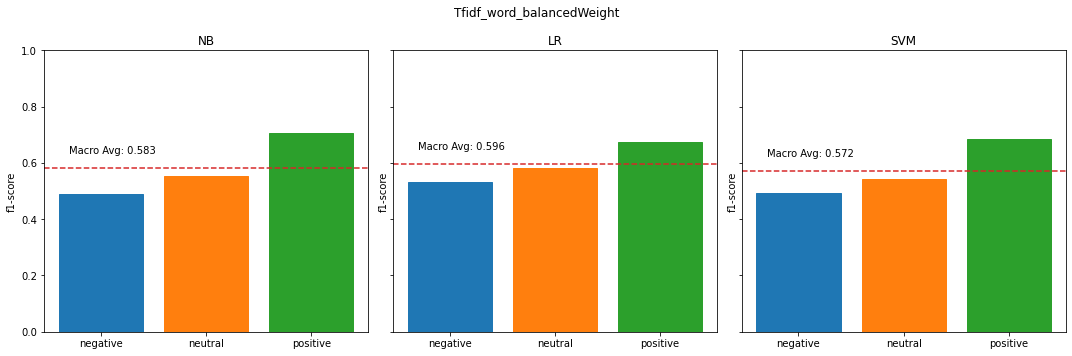

In [28]:
display(Markdown("**TfidfVectorizer_Unigram with Balanced Class Weight (No Resampling)**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Tfidf_word_NB_balancedWeight.pickle'
report_save ='models/Tfidf_word_NB_balancedWeight_report.csv' 
classifier = MultinomialNB(fit_prior=False)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Tfidf_word_LR_balancedWeight.pickle'
report_save ='models/Tfidf_word_LR_balancedWeight_report.csv' 
classifier = LogisticRegression(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Tfidf_word_SVM_balancedWeight.pickle'
report_save ='models/Tfidf_word_SVM_balancedWeight_report.csv' 
classifier = LinearSVC(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='Tfidf_word',classifiers=['NB','LR','SVM'],mode='balancedWeight')

**TfidfVectorizer_Unigram with SMOTE Resampling**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.76      0.88      0.82      7510
     neutral       0.80      0.74      0.77      7510
    positive       0.80      0.74      0.77      7510

    accuracy                           0.78     22530
   macro avg       0.79      0.78      0.78     22530
weighted avg       0.79      0.78      0.78     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.45      0.64      0.53       404
     neutral       0.57      0.55      0.56       623
    positive       0.74      0.63      0.68       939

    accuracy                           0.61      1966
   macro avg       0.59      0.61      0.59      1966
weighted avg       0.63      0.61      0.61      1966

Time to train:  0.38s
Time to predict:  0.30s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.83      0.90      0.86      7510
     neutral       0.81      0.81      0.81      7510
    positive       0.84      0.77      0.81      7510

    accuracy                           0.83     22530
   macro avg       0.83      0.83      0.83     22530
weighted avg       0.83      0.83      0.83     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.48      0.57      0.52       404
     neutral       0.52      0.60      0.56       623
    positive       0.75      0.62      0.68       939

    accuracy                           0.60      1966
   macro avg       0.58      0.59      0.58      1966
weighted avg       0.62      0.60      0.61      1966

Time to train:  25.76s
Time to predict:  0.35s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.90      0.95      0.93      7510
     neutral       0.90      0.89      0.89      7510
    positive       0.90      0.86      0.88      7510

    accuracy                           0.90     22530
   macro avg       0.90      0.90      0.90     22530
weighted avg       0.90      0.90      0.90     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.52      0.49       404
     neutral       0.51      0.56      0.53       623
    positive       0.71      0.63      0.67       939

    accuracy                           0.58      1966
   macro avg       0.56      0.57      0.56      1966
weighted avg       0.60      0.58      0.59      1966

Time to train:  1.24s
Time to predict:  0.33s


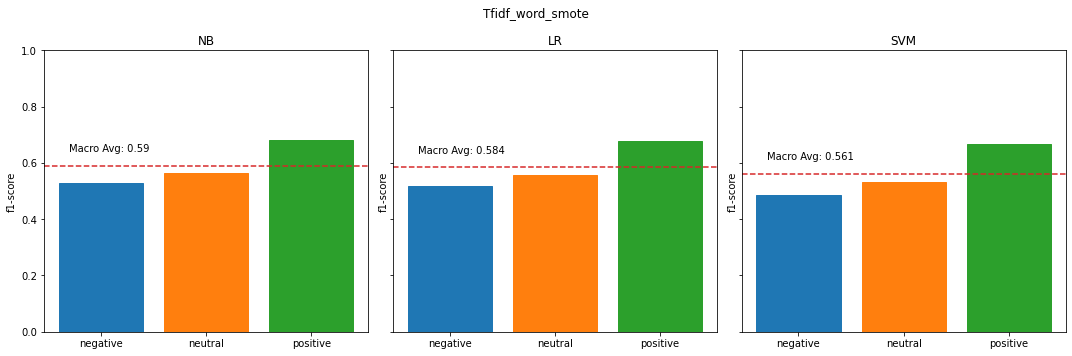

In [29]:
display(Markdown("**TfidfVectorizer_Unigram with SMOTE Resampling**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Tfidf_word_NB_smote.pickle'
report_save ='models/Tfidf_word_NB_smote_report.csv' 
classifier = MultinomialNB()
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Tfidf_word_LR_smote.pickle'
report_save ='models/Tfidf_word_LR_smote_report.csv' 
classifier = LogisticRegression(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Tfidf_word_SVM_smote.pickle'
report_save ='models/Tfidf_word_SVM_smote_report.csv' 
classifier = LinearSVC(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Tfidf_word',classifiers=['NB','LR','SVM'],mode='smote')


**TfidfVectorizer_Unigram with Resampling and Data Normalisation**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.78      0.89      0.83      7510
     neutral       0.82      0.75      0.78      7510
    positive       0.81      0.76      0.78      7510

    accuracy                           0.80     22530
   macro avg       0.80      0.80      0.80     22530
weighted avg       0.80      0.80      0.80     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.44      0.60      0.51       404
     neutral       0.55      0.54      0.54       623
    positive       0.72      0.62      0.66       939

    accuracy                           0.59      1966
   macro avg       0.57      0.58      0.57      1966
weighted avg       0.61      0.59      0.59      1966

Time to train:  2.09s
Time to predict:  1.58s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.90      0.95      0.92      7510
     neutral       0.89      0.89      0.89      7510
    positive       0.90      0.86      0.88      7510

    accuracy                           0.90     22530
   macro avg       0.90      0.90      0.90     22530
weighted avg       0.90      0.90      0.90     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.51      0.48       404
     neutral       0.50      0.55      0.52       623
    positive       0.70      0.62      0.66       939

    accuracy                           0.57      1966
   macro avg       0.55      0.56      0.55      1966
weighted avg       0.59      0.57      0.58      1966

Time to train:  29.29s
Time to predict:  1.58s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.94      0.98      0.96      7510
     neutral       0.94      0.94      0.94      7510
    positive       0.94      0.91      0.92      7510

    accuracy                           0.94     22530
   macro avg       0.94      0.94      0.94     22530
weighted avg       0.94      0.94      0.94     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.41      0.45      0.43       404
     neutral       0.49      0.52      0.50       623
    positive       0.67      0.61      0.64       939

    accuracy                           0.55      1966
   macro avg       0.52      0.53      0.53      1966
weighted avg       0.56      0.55      0.55      1966

Time to train:  3.13s
Time to predict:  1.61s


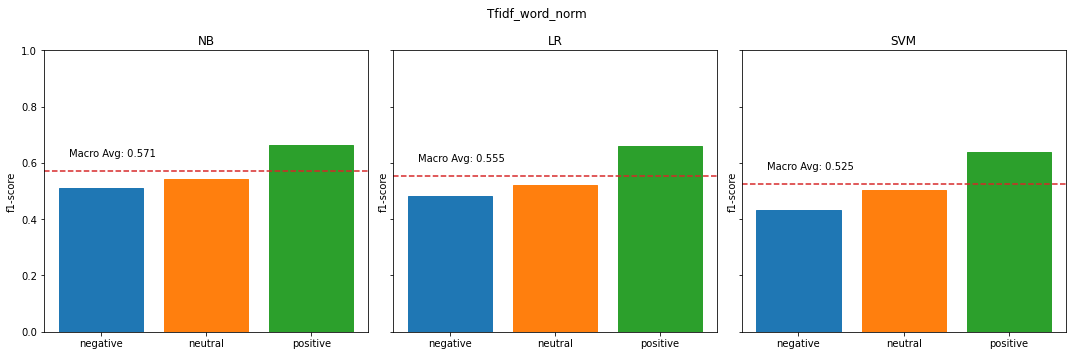

In [30]:
display(Markdown("**TfidfVectorizer_Unigram with Resampling and Data Normalisation**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Tfidf_word_NB_norm.pickle'
report_save ='models/Tfidf_word_NB_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB())
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Tfidf_word_LR_norm.pickle'
report_save ='models/Tfidf_word_LR_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Tfidf_word_SVM_norm.pickle'
report_save ='models/Tfidf_word_SVM_norm_report.csv' 
classifier = make_pipeline(MinMaxScaler(), LinearSVC(max_iter=500))
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Tfidf_word',classifiers=['NB','LR','SVM'],mode='norm')


***Oberservations:***
- *In comparision with word count vectorization, LR and SVM performed better with Tfidf vectorization, with +3% and +5% improvement in macro average f1 score; however, NB is slightly worse off (c. -1%)*
- *Comparing class_weight with resampling, LR and SVM achieved slightly results (+1%), whereas NB is better with SMOTE resampling*
- *Similar to word count vectorization, all three classifiers underformed with data normalization by 2-4%*


<font color=blue> **Preliminary Conclusion:** </font>

<font color=blue> - In terms of macro-average F1 score, LR (59.6%) works best with TfidfVectorizer (unigram) and class_weight set to 'balanced'.</font>

<font color=blue> - No data scaling or resampling required.</font>


## 

#### TF-IDF Vectorizer with Bigram

In [31]:
# TfidfVectorizer_bigram

vectorizer = TfidfVectorizer(analyzer='word', min_df = 3, ngram_range = (2,2))  # initiate vectorizer
start_time = time.time()

# Fit vectorizer on corpus
vectorizer.fit(corpus)
train_time = time.time()

# Data vectorization
x_train_vect = vectorizer.transform(x_train).toarray()
x_valid_vect = vectorizer.transform(x_valid).toarray()
transform_time = time.time()

# Data resampling to adjust for class imbalance
smote = SMOTE()
x_train_res, y_train_res = smote.fit_sample(x_train_vect, y_train)
resample_time = time.time()

print(f"vectorizer_fitting: {train_time - start_time: .2f}s")
print(f"data_vectorization: {transform_time - train_time: .2f}s")
print(f"data_resampling: {resample_time - transform_time: .2f}s")

# Save vectorizer
with open('models/TfidfVectorizer_bigram.pickle','wb') as f:
    pickle.dump(vectorizer, f)



vectorizer_fitting:  0.42s
data_vectorization:  0.63s
data_resampling:  763.33s


**TfidfVectorizer_bigram with Balanced Class Weight (No Resampling)**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.69      0.80      0.74      3226
     neutral       0.79      0.79      0.79      4986
    positive       0.86      0.80      0.83      7510

    accuracy                           0.80     15722
   macro avg       0.78      0.80      0.79     15722
weighted avg       0.80      0.80      0.80     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.43      0.50      0.46       404
     neutral       0.51      0.49      0.50       623
    positive       0.64      0.61      0.62       939

    accuracy                           0.55      1966
   macro avg       0.52      0.53      0.53      1966
weighted avg       0.55      0.55      0.55      1966

Time to train:  0.88s
Time to predict:  0.54s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.73      0.91      0.81      3226
     neutral       0.82      0.84      0.83      4986
    positive       0.92      0.80      0.86      7510

    accuracy                           0.84     15722
   macro avg       0.82      0.85      0.83     15722
weighted avg       0.85      0.84      0.84     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.40      0.49      0.44       404
     neutral       0.50      0.53      0.51       623
    positive       0.66      0.57      0.61       939

    accuracy                           0.54      1966
   macro avg       0.52      0.53      0.52      1966
weighted avg       0.56      0.54      0.55      1966

Time to train:  30.46s
Time to predict:  0.47s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.88      0.96      0.92      3226
     neutral       0.93      0.93      0.93      4986
    positive       0.96      0.92      0.94      7510

    accuracy                           0.93     15722
   macro avg       0.92      0.94      0.93     15722
weighted avg       0.93      0.93      0.93     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.38      0.42      0.40       404
     neutral       0.48      0.49      0.49       623
    positive       0.63      0.60      0.61       939

    accuracy                           0.53      1966
   macro avg       0.50      0.50      0.50      1966
weighted avg       0.53      0.53      0.53      1966

Time to train:  1.26s
Time to predict:  0.43s


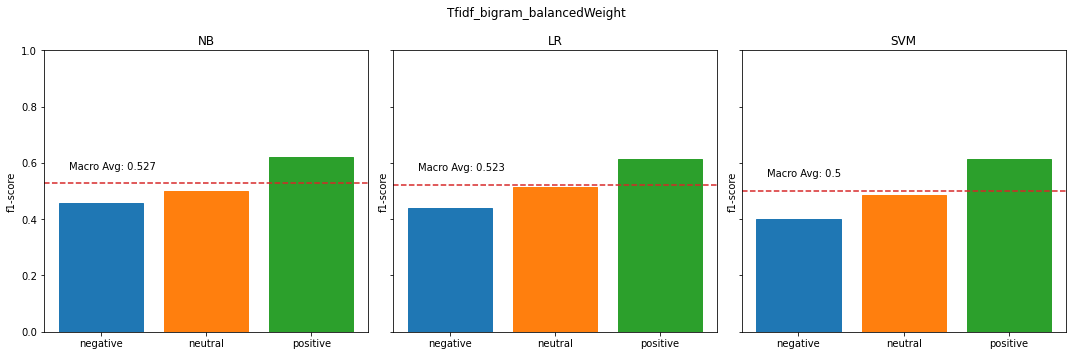

In [32]:
display(Markdown("**TfidfVectorizer_bigram with Balanced Class Weight (No Resampling)**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Tfidf_bigram_NB_balancedWeight.pickle'
report_save ='models/Tfidf_bigram_NB_balancedWeight_report.csv' 
classifier = MultinomialNB(fit_prior=False)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Tfidf_bigram_LR_balancedWeight.pickle'
report_save ='models/Tfidf_bigram_LR_balancedWeight_report.csv' 
classifier = LogisticRegression(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Tfidf_bigram_SVM_balancedWeight.pickle'
report_save ='models/Tfidf_bigram_SVM_balancedWeight_report.csv' 
classifier = LinearSVC(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='Tfidf_bigram',classifiers=['NB','LR','SVM'],mode='balancedWeight')

**TfidfVectorizer_Bigram with SMOTE Resampling**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.80      0.88      0.84      7510
     neutral       0.82      0.80      0.81      7510
    positive       0.83      0.77      0.80      7510

    accuracy                           0.82     22530
   macro avg       0.82      0.82      0.82     22530
weighted avg       0.82      0.82      0.82     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.40      0.54      0.46       404
     neutral       0.50      0.48      0.49       623
    positive       0.66      0.58      0.62       939

    accuracy                           0.54      1966
   macro avg       0.52      0.53      0.52      1966
weighted avg       0.56      0.54      0.54      1966

Time to train:  0.85s
Time to predict:  0.54s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.80      0.92      0.85      7510
     neutral       0.86      0.79      0.83      7510
    positive       0.88      0.82      0.85      7510

    accuracy                           0.84     22530
   macro avg       0.85      0.84      0.84     22530
weighted avg       0.85      0.84      0.84     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.39      0.49      0.43       404
     neutral       0.49      0.50      0.50       623
    positive       0.65      0.56      0.60       939

    accuracy                           0.53      1966
   macro avg       0.51      0.52      0.51      1966
weighted avg       0.55      0.53      0.53      1966

Time to train:  49.54s
Time to predict:  0.49s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.87      0.97      0.92      7510
     neutral       0.94      0.88      0.91      7510
    positive       0.95      0.92      0.93      7510

    accuracy                           0.92     22530
   macro avg       0.92      0.92      0.92     22530
weighted avg       0.92      0.92      0.92     22530


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.36      0.45      0.40       404
     neutral       0.48      0.49      0.48       623
    positive       0.64      0.55      0.59       939

    accuracy                           0.51      1966
   macro avg       0.49      0.50      0.49      1966
weighted avg       0.53      0.51      0.52      1966

Time to train:  1.71s
Time to predict:  0.55s


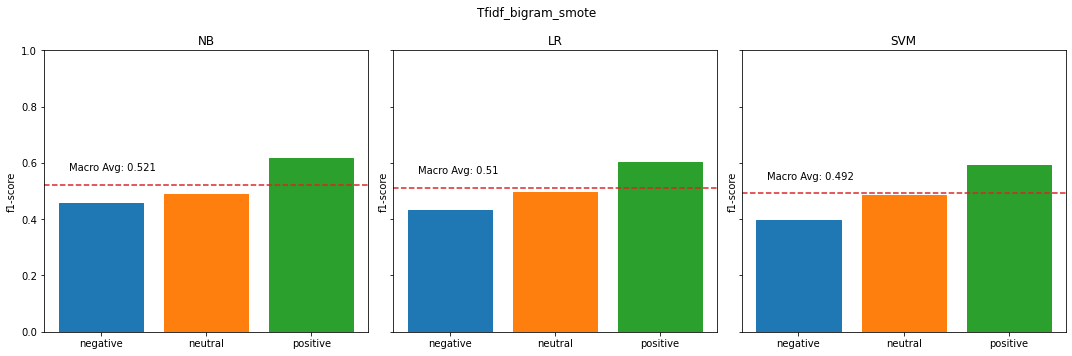

In [33]:
display(Markdown("**TfidfVectorizer_Bigram with SMOTE Resampling**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Tfidf_bigram_NB_smote.pickle'
report_save ='models/Tfidf_bigram_NB_smote_report.csv' 
classifier = MultinomialNB()
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Tfidf_bigram_LR_smote.pickle'
report_save ='models/Tfidf_bigram_LR_smote_report.csv' 
classifier = LogisticRegression(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Tfidf_bigram_SVM_smote.pickle'
report_save ='models/Tfidf_bigram_SVM_smote_report.csv' 
classifier = LinearSVC(max_iter=500)
train_classifier(classifier, x_train_res, y_train_res, x_valid_vect, y_valid, model_save, report_save)


plot_f1(vectorizer='Tfidf_bigram',classifiers=['NB','LR','SVM'],mode='smote')


***Oberservations:***
- *Tfidf bigram underperforms Tfidf unigram by c. 6-7% throughout all three classifiers*
- *Similar as before, data scaling by normalization is counter-effective*


<font color=blue> **Preliminary Conclusion:** </font>

<font color=blue> - Tfidf Bigram Vectorizer should be rejected. 

## 

#### CountVectorizer with Unigram, Bigram and Trigram

In [34]:
# Initialize vectorizer
vectorizer = CountVectorizer(analyzer='word', min_df = 3, ngram_range = (1,3)) 
start_time = time.time()

# Fit vectorizer on corpus
vectorizer.fit(corpus)
train_time = time.time()

# Data vectorization
x_train_vect = vectorizer.transform(x_train).toarray()
x_valid_vect = vectorizer.transform(x_valid).toarray()
transform_time = time.time()

print(f"vectorizer_fitting: {train_time - start_time: .2f}s")
print(f"data_vectorization: {transform_time - train_time: .2f}s")

# Save vectorizer
with open('models/CountVectorizer_uni_bi_trigram.pickle','wb') as f:
    pickle.dump(vectorizer, f)


vectorizer_fitting:  0.88s
data_vectorization:  1.25s


**CountVectorizer_unigram, bigram and trigram with Balanced Class Weight (No Resampling)**

*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.68      0.86      0.76      3226
     neutral       0.80      0.80      0.80      4986
    positive       0.89      0.79      0.84      7510

    accuracy                           0.81     15722
   macro avg       0.79      0.82      0.80     15722
weighted avg       0.82      0.81      0.81     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.55      0.50       404
     neutral       0.54      0.55      0.54       623
    positive       0.70      0.63      0.66       939

    accuracy                           0.59      1966
   macro avg       0.57      0.58      0.57      1966
weighted avg       0.60      0.59      0.59      1966

Time to train:  16.69s
Time to predict:  3.14s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.93      1.00      0.96      3226
     neutral       0.99      0.99      0.99      4986
    positive       1.00      0.96      0.98      7510

    accuracy                           0.98     15722
   macro avg       0.97      0.98      0.98     15722
weighted avg       0.98      0.98      0.98     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.48      0.47       404
     neutral       0.53      0.58      0.55       623
    positive       0.70      0.65      0.68       939

    accuracy                           0.59      1966
   macro avg       0.57      0.57      0.57      1966
weighted avg       0.60      0.59      0.60      1966

Time to train:  87.56s
Time to predict:  5.23s


*Support Vector Machine*

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Training Set Performance:
               precision    recall  f1-score   support

    negative       0.93      1.00      0.97      3226
     neutral       1.00      0.99      0.99      4986
    positive       1.00      0.97      0.99      7510

    accuracy                           0.98     15722
   macro avg       0.98      0.99      0.98     15722
weighted avg       0.98      0.98      0.98     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.41      0.38      0.40       404
     neutral       0.50      0.52      0.51       623
    positive       0.66      0.67      0.67       939

    accuracy                           0.56      1966
   macro avg       0.53      0.52      0.52      1966
weighted avg       0.56      0.56      0.56      1966

Time to train:  5.81s
Time to predict:  2.35s


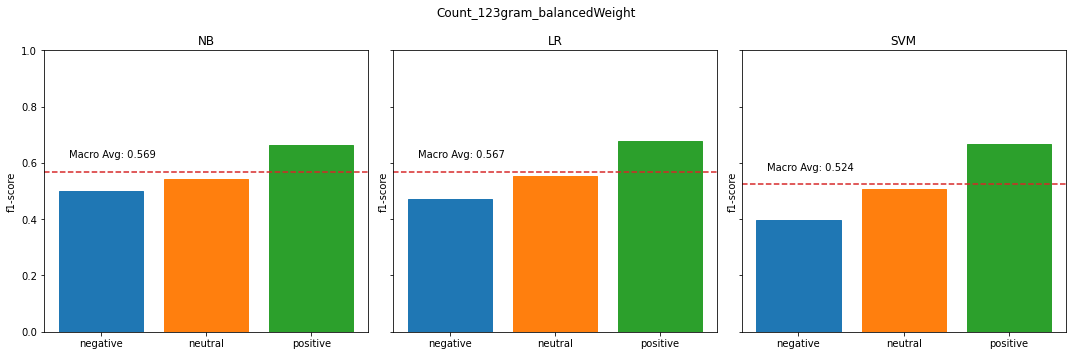

In [35]:
display(Markdown("**CountVectorizer_unigram, bigram and trigram with Balanced Class Weight (No Resampling)**"))

display(Markdown("*Naive Bayes*"))
model_save = 'models/Count_123gram_NB_balancedWeight.pickle'
report_save ='models/Count_123gram_NB_balancedWeight_report.csv' 
classifier = MultinomialNB(fit_prior=False)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Count_123gram_LR_balancedWeight.pickle'
report_save ='models/Count_123gram_LR_balancedWeight_report.csv' 
classifier = LogisticRegression(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Count_123gram_SVM_balancedWeight.pickle'
report_save ='models/Count_123gram_SVM_balancedWeight_report.csv' 
classifier = LinearSVC(class_weight='balanced',max_iter=500)
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='Count_123gram',classifiers=['NB','LR','SVM'],mode='balancedWeight')

***Oberservations:***
- *Count vectorization with unigram, bigram and trigram combined achieves similar results as Count vectorization with only unigram, however it takes much longer to train*


<font color=blue> **Preliminary Conclusion:** </font>

<font color=blue> - CountVectorizer with a combination of 1-3gram should be rejected. 

## 

#### GloVe Embeddings (pre-trained on Twitter)

In [36]:
import gensim.downloader as api
# Download pre-trained embeddings
model_glove_twitter = api.load("glove-twitter-25")

In [53]:
import importlib
import sys
importlib.reload(sys.modules['modules.ML_classifiers_SUN'])
from modules.ML_classifiers_SUN import WordEmbeddingVectorizer, vectorize

**GloVe_Twitter25_AggMean**

data_vectorization:  0.70s


*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.34      0.61      0.44      3226
     neutral       0.42      0.57      0.48      4986
    positive       0.67      0.28      0.39      7510

    accuracy                           0.44     15722
   macro avg       0.47      0.49      0.44     15722
weighted avg       0.52      0.44      0.43     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.32      0.58      0.41       404
     neutral       0.44      0.60      0.51       623
    positive       0.69      0.27      0.39       939

    accuracy                           0.44      1966
   macro avg       0.48      0.49      0.44      1966
weighted avg       0.53      0.44      0.43      1966

Time to train:  0.04s
Time to predict:  0.00s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.40      0.64      0.49      3226
     neutral       0.47      0.45      0.46      4986
    positive       0.68      0.53      0.59      7510

    accuracy                           0.52     15722
   macro avg       0.52      0.54      0.51     15722
weighted avg       0.56      0.52      0.53     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.37      0.60      0.46       404
     neutral       0.47      0.46      0.46       623
    positive       0.70      0.53      0.60       939

    accuracy                           0.52      1966
   macro avg       0.51      0.53      0.51      1966
weighted avg       0.56      0.52      0.53      1966

Time to train:  0.61s
Time to predict:  0.01s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.42      0.54      0.47      3226
     neutral       0.49      0.37      0.43      4986
    positive       0.64      0.66      0.65      7510

    accuracy                           0.55     15722
   macro avg       0.52      0.53      0.52     15722
weighted avg       0.55      0.55      0.54     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.39      0.53      0.45       404
     neutral       0.49      0.38      0.43       623
    positive       0.65      0.65      0.65       939

    accuracy                           0.54      1966
   macro avg       0.51      0.52      0.51      1966
weighted avg       0.55      0.54      0.54      1966

Time to train:  0.37s
Time to predict:  0.00s


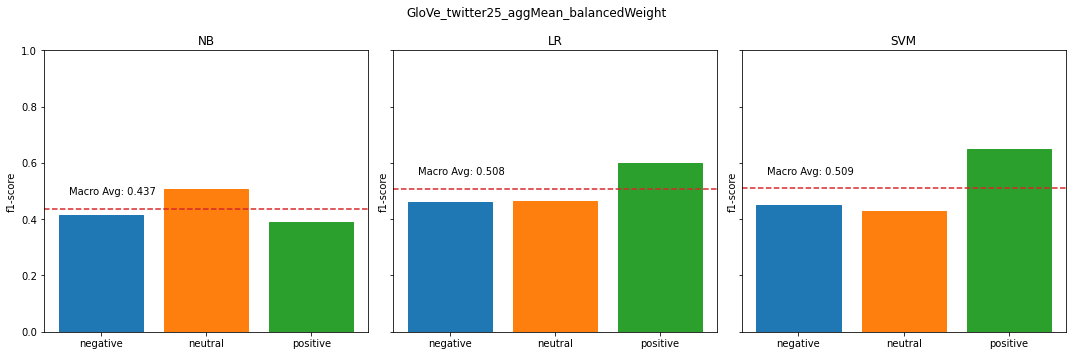

In [58]:
display(Markdown("**GloVe_Twitter25_AggMean**"))

start_time = time.time()
vectorizer = WordEmbeddingVectorizer(model_glove_twitter,mode='aggregate',by='mean')

# Data vectorization
x_train_vect = vectorizer.transform(x_train) 
x_valid_vect = vectorizer.transform(x_valid)
transform_time = time.time()

print(f"data_vectorization: {transform_time - start_time: .2f}s")

# Save vectorizer
#with open('models/GloVe_twitter25_aggMean.pickle','wb') as f:
#    pickle.dump(vectorizer, f)


display(Markdown("*Naive Bayes*"))
model_save = 'models/GloVe_twitter25_aggMean_NB_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMean_NB_balancedWeight_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB(fit_prior=False))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/GloVe_twitter25_aggMean_LR_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMean_LR_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LogisticRegression(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/GloVe_twitter25_aggMean_SVM_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMean_SVM_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LinearSVC(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='GloVe_twitter25_aggMean',classifiers=['NB','LR','SVM'],mode='balancedWeight')



**GloVe_Twitter25_AggMax**

data_vectorization:  1.10s


*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.34      0.56      0.42      3226
     neutral       0.42      0.48      0.45      4986
    positive       0.62      0.39      0.48      7510

    accuracy                           0.45     15722
   macro avg       0.46      0.47      0.45     15722
weighted avg       0.50      0.45      0.46     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.32      0.53      0.40       404
     neutral       0.43      0.52      0.47       623
    positive       0.62      0.36      0.45       939

    accuracy                           0.44      1966
   macro avg       0.46      0.47      0.44      1966
weighted avg       0.50      0.44      0.45      1966

Time to train:  0.04s
Time to predict:  0.00s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.35      0.61      0.44      3226
     neutral       0.43      0.38      0.41      4986
    positive       0.62      0.46      0.53      7510

    accuracy                           0.47     15722
   macro avg       0.47      0.49      0.46     15722
weighted avg       0.50      0.47      0.47     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.33      0.56      0.42       404
     neutral       0.44      0.41      0.43       623
    positive       0.62      0.45      0.52       939

    accuracy                           0.46      1966
   macro avg       0.46      0.48      0.45      1966
weighted avg       0.50      0.46      0.47      1966

Time to train:  0.42s
Time to predict:  0.01s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.37      0.45      0.41      3226
     neutral       0.45      0.33      0.38      4986
    positive       0.59      0.63      0.61      7510

    accuracy                           0.50     15722
   macro avg       0.47      0.47      0.46     15722
weighted avg       0.50      0.50      0.49     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.36      0.44      0.39       404
     neutral       0.45      0.35      0.40       623
    positive       0.58      0.60      0.59       939

    accuracy                           0.49      1966
   macro avg       0.46      0.47      0.46      1966
weighted avg       0.49      0.49      0.49      1966

Time to train:  0.39s
Time to predict:  0.01s


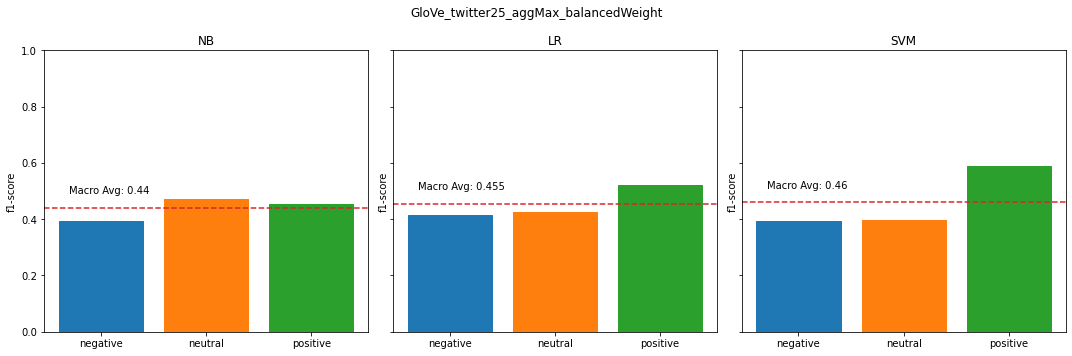

In [59]:
display(Markdown("**GloVe_Twitter25_AggMax**"))

start_time = time.time()
vectorizer = WordEmbeddingVectorizer(model_glove_twitter,mode='aggregate',by='max')

# Data vectorization
x_train_vect = vectorizer.transform(x_train) 
x_valid_vect = vectorizer.transform(x_valid)
transform_time = time.time()

print(f"data_vectorization: {transform_time - start_time: .2f}s")

# Save vectorizer
#with open('models/GloVe_twitter25_aggMean.pickle','wb') as f:
#    pickle.dump(vectorizer, f)


display(Markdown("*Naive Bayes*"))
model_save = 'models/GloVe_twitter25_aggMax_NB_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMax_NB_balancedWeight_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB(fit_prior=False))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/GloVe_twitter25_aggMax_LR_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMax_LR_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LogisticRegression(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/GloVe_twitter25_aggMax_SVM_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggMax_SVM_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LinearSVC(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='GloVe_twitter25_aggMax',classifiers=['NB','LR','SVM'],mode='balancedWeight')



**GloVe_Twitter25_Sum**

data_vectorization:  0.62s


*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.35      0.57      0.43      3226
     neutral       0.42      0.59      0.49      4986
    positive       0.68      0.31      0.42      7510

    accuracy                           0.45     15722
   macro avg       0.48      0.49      0.45     15722
weighted avg       0.53      0.45      0.45     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.33      0.56      0.42       404
     neutral       0.42      0.59      0.49       623
    positive       0.68      0.30      0.41       939

    accuracy                           0.44      1966
   macro avg       0.48      0.48      0.44      1966
weighted avg       0.53      0.44      0.44      1966

Time to train:  0.04s
Time to predict:  0.00s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.40      0.64      0.49      3226
     neutral       0.47      0.45      0.46      4986
    positive       0.68      0.53      0.59      7510

    accuracy                           0.52     15722
   macro avg       0.52      0.54      0.51     15722
weighted avg       0.56      0.52      0.53     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.37      0.60      0.46       404
     neutral       0.47      0.46      0.46       623
    positive       0.70      0.53      0.60       939

    accuracy                           0.52      1966
   macro avg       0.51      0.53      0.51      1966
weighted avg       0.56      0.52      0.53      1966

Time to train:  0.63s
Time to predict:  0.01s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.42      0.54      0.47      3226
     neutral       0.49      0.37      0.43      4986
    positive       0.64      0.66      0.65      7510

    accuracy                           0.55     15722
   macro avg       0.52      0.53      0.52     15722
weighted avg       0.55      0.55      0.54     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.39      0.53      0.45       404
     neutral       0.49      0.38      0.43       623
    positive       0.65      0.65      0.65       939

    accuracy                           0.54      1966
   macro avg       0.51      0.52      0.51      1966
weighted avg       0.55      0.54      0.54      1966

Time to train:  0.34s
Time to predict:  0.00s


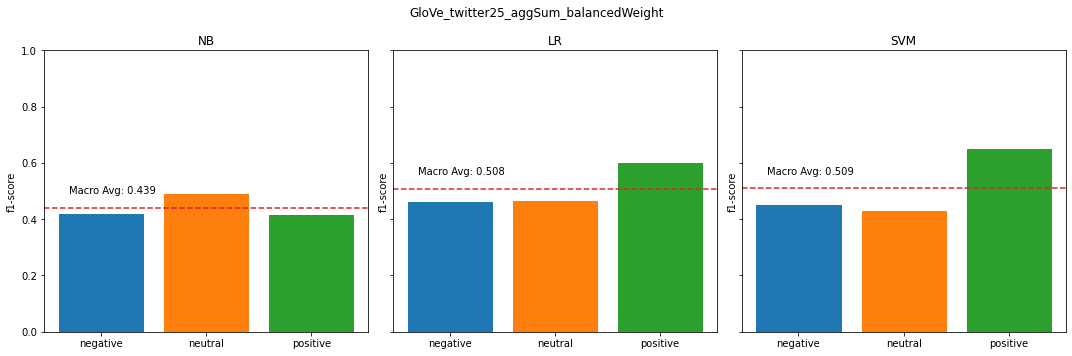

In [61]:
display(Markdown("**GloVe_Twitter25_Sum**"))

start_time = time.time()
vectorizer = WordEmbeddingVectorizer(model_glove_twitter,mode='aggregate',by='sum')

# Data vectorization
x_train_vect = vectorizer.transform(x_train) 
x_valid_vect = vectorizer.transform(x_valid)
transform_time = time.time()

print(f"data_vectorization: {transform_time - start_time: .2f}s")

# Save vectorizer
#with open('models/GloVe_twitter25_aggMean.pickle','wb') as f:
#    pickle.dump(vectorizer, f)


display(Markdown("*Naive Bayes*"))
model_save = 'models/GloVe_twitter25_aggSum_NB_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggSum_NB_balancedWeight_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB(fit_prior=False))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/GloVe_twitter25_aggSum_LR_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggSum_LR_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LogisticRegression(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/GloVe_twitter25_aggSum_SVM_balancedWeight.pickle'
report_save ='models/GloVe_twitter25_aggSum_SVM_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LinearSVC(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='GloVe_twitter25_aggSum',classifiers=['NB','LR','SVM'],mode='balancedWeight')



**GloVe_Twitter200_AggMean**

data_vectorization:  0.93s


*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.37      0.62      0.46      3226
     neutral       0.43      0.57      0.49      4986
    positive       0.71      0.35      0.47      7510

    accuracy                           0.48     15722
   macro avg       0.50      0.51      0.48     15722
weighted avg       0.55      0.48      0.48     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.35      0.58      0.43       404
     neutral       0.45      0.60      0.51       623
    positive       0.73      0.36      0.48       939

    accuracy                           0.48      1966
   macro avg       0.51      0.51      0.48      1966
weighted avg       0.56      0.48      0.48      1966

Time to train:  0.07s
Time to predict:  0.03s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.45      0.68      0.54      3226
     neutral       0.52      0.52      0.52      4986
    positive       0.74      0.57      0.64      7510

    accuracy                           0.58     15722
   macro avg       0.57      0.59      0.57     15722
weighted avg       0.61      0.58      0.58     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.42      0.63      0.50       404
     neutral       0.50      0.52      0.51       623
    positive       0.73      0.55      0.63       939

    accuracy                           0.56      1966
   macro avg       0.55      0.57      0.55      1966
weighted avg       0.59      0.56      0.56      1966

Time to train:  1.02s
Time to predict:  0.03s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.49      0.61      0.55      3226
     neutral       0.54      0.48      0.51      4986
    positive       0.69      0.68      0.68      7510

    accuracy                           0.60     15722
   macro avg       0.58      0.59      0.58     15722
weighted avg       0.60      0.60      0.60     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.45      0.56      0.50       404
     neutral       0.52      0.47      0.49       623
    positive       0.69      0.66      0.68       939

    accuracy                           0.58      1966
   macro avg       0.55      0.56      0.56      1966
weighted avg       0.59      0.58      0.58      1966

Time to train:  1.49s
Time to predict:  0.03s


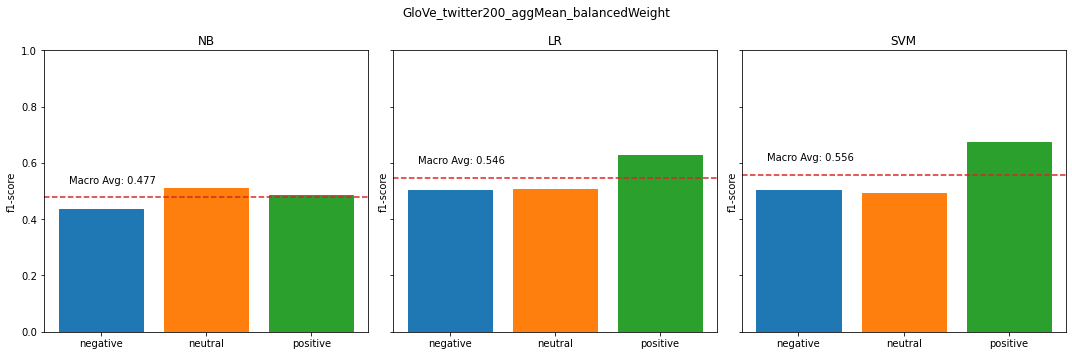

In [62]:
model_glove_twitter = api.load("glove-twitter-200")

display(Markdown("**GloVe_Twitter200_AggMean**"))

start_time = time.time()
vectorizer = WordEmbeddingVectorizer(model_glove_twitter,mode='aggregate',by='mean')

# Data vectorization
x_train_vect = vectorizer.transform(x_train) 
x_valid_vect = vectorizer.transform(x_valid)
transform_time = time.time()

print(f"data_vectorization: {transform_time - start_time: .2f}s")

display(Markdown("*Naive Bayes*"))
model_save = 'models/GloVe_twitter200_aggMean_NB_balancedWeight.pickle'
report_save ='models/GloVe_twitter200_aggMean_NB_balancedWeight_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB(fit_prior=False))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/GloVe_twitter200_aggMean_LR_balancedWeight.pickle'
report_save ='models/GloVe_twitter200_aggMean_LR_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LogisticRegression(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/GloVe_twitter200_aggMean_SVM_balancedWeight.pickle'
report_save ='models/GloVe_twitter200_aggMean_SVM_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LinearSVC(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='GloVe_twitter200_aggMean',classifiers=['NB','LR','SVM'],mode='balancedWeight')



In [ ]:
# Save best performing vectorizer
with open('models/GloVe_twitter200_aggMean.pickle','wb') as f:
    pickle.dump(vectorizer, f)


***Oberservations:***
- *For GloVe embeddings (pretrained on twitter data), higher features with 200D is better than 25D for all three classifiers (c. 4-5% performance increase)*
- *To aggregate, taking mean and sum are better than taking the max (c. 5% difference)*
- *For GloVe Embeddings with 200D and aggregate by mean, SVM gives the best macro average f1 score at c. 55.6%*


# 

#### Word2Vec Embeddings

**Word2Vec_News300_AggMean**

data_vectorization:  1.02s


*Naive Bayes*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.36      0.64      0.46      3226
     neutral       0.44      0.58      0.50      4986
    positive       0.72      0.32      0.44      7510

    accuracy                           0.47     15722
   macro avg       0.50      0.51      0.47     15722
weighted avg       0.55      0.47      0.46     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.36      0.63      0.46       404
     neutral       0.45      0.59      0.51       623
    positive       0.73      0.34      0.46       939

    accuracy                           0.48      1966
   macro avg       0.51      0.52      0.48      1966
weighted avg       0.56      0.48      0.48      1966

Time to train:  0.09s
Time to predict:  0.05s


*Logistic Regression*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.50      0.71      0.58      3226
     neutral       0.56      0.57      0.57      4986
    positive       0.76      0.61      0.68      7510

    accuracy                           0.62     15722
   macro avg       0.61      0.63      0.61     15722
weighted avg       0.64      0.62      0.62     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.46      0.69      0.56       404
     neutral       0.55      0.56      0.55       623
    positive       0.77      0.60      0.68       939

    accuracy                           0.61      1966
   macro avg       0.60      0.62      0.60      1966
weighted avg       0.64      0.61      0.61      1966

Time to train:  1.24s
Time to predict:  0.07s


*Support Vector Machine*


Training Set Performance:
               precision    recall  f1-score   support

    negative       0.53      0.65      0.58      3226
     neutral       0.58      0.54      0.56      4986
    positive       0.73      0.69      0.71      7510

    accuracy                           0.63     15722
   macro avg       0.61      0.63      0.62     15722
weighted avg       0.64      0.63      0.64     15722


Validation Set Performance:
               precision    recall  f1-score   support

    negative       0.50      0.65      0.57       404
     neutral       0.58      0.54      0.56       623
    positive       0.74      0.69      0.71       939

    accuracy                           0.63      1966
   macro avg       0.61      0.62      0.61      1966
weighted avg       0.64      0.63      0.63      1966

Time to train:  2.07s
Time to predict:  0.05s


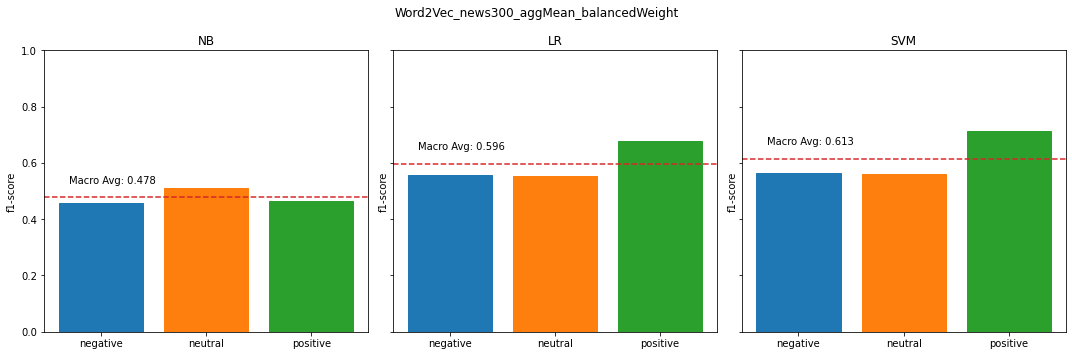

In [64]:
model_w2v_news = api.load("word2vec-google-news-300")
# Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",

display(Markdown("**Word2Vec_News300_AggMean**"))

start_time = time.time()
vectorizer = WordEmbeddingVectorizer(model_w2v_news,mode='aggregate',by='mean')

# Data vectorization
x_train_vect = vectorizer.transform(x_train) 
x_valid_vect = vectorizer.transform(x_valid)
transform_time = time.time()

print(f"data_vectorization: {transform_time - start_time: .2f}s")

display(Markdown("*Naive Bayes*"))
model_save = 'models/Word2Vec_news300_aggMean_NB_balancedWeight.pickle'
report_save ='models/Word2Vec_news300_aggMean_NB_balancedWeight_report.csv' 
classifier = make_pipeline(MinMaxScaler(), MultinomialNB(fit_prior=False))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Logistic Regression*"))
model_save = 'models/Word2Vec_news300_aggMean_LR_balancedWeight.pickle'
report_save ='models/Word2Vec_news300_aggMean_LR_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LogisticRegression(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)


display(Markdown("*Support Vector Machine*"))
model_save = 'models/Word2Vec_news300_aggMean_SVM_balancedWeight.pickle'
report_save ='models/Word2Vec_news300_aggMean_SVM_balancedWeight_report.csv' 
classifier = make_pipeline(Normalizer(), LinearSVC(class_weight='balanced',max_iter=500))
train_classifier(classifier, x_train_vect, y_train, x_valid_vect, y_valid, model_save, report_save)

plot_f1(vectorizer='Word2Vec_news300_aggMean',classifiers=['NB','LR','SVM'],mode='balancedWeight')

# Save vectorizer
with open('models/Word2Vec_news300_aggMean.pickle','wb') as f:
    pickle.dump(vectorizer, f)


***Oberservations:***
- *For Word2Vec embeddings (pretrained on google news), SVM peformed better than LR and NB*
- *It achieved the highest macro average f1 score (c. 61%) amongst all classificaiton methods tried so far*



# 

### Select Best Performing Classifier Models

In [67]:
select_models = ['Count_word_NB_balancedWeight', 'Tfidf_word_LR_balancedWeight','Word2Vec_news300_aggMean_SVM_balancedWeight']

select_vectorizers = ['CountVectorizer_unigram.pickle','TfidfVectorizer_unigram.pickle','Word2Vec_news300_aggMean.pickle']


In [73]:
def plot_score(models,metric='f1-score'): 
    
    cols = len(models)        
    fig,ax = plt.subplots(1,cols, tight_layout=True,sharex=True,sharey=True,figsize=(15,5))
    fig.suptitle("classification performance on validation set by "+metric)
    
    for j in range(cols):
        report_name = 'models/'+ models[j]+'_report.csv'
        df_report = pd.read_csv(report_name)
        data_bar = df_report[df_report['report']=='valid'].iloc[[0,1,2]][metric]
        data_line = df_report[df_report['report']=='valid'].iloc[[4]][metric].values.item()
        ax[j].set_title(models[j])
        ax[j].set_ylabel(metric)
        x = ax[j].bar(['negative','neutral','positive'],data_bar)
        x[0].set_color('C0')
        x[1].set_color('C1')
        x[2].set_color('C2')
        ax[j].axhline(data_line,color='C3', linestyle='dashed')
        ax[j].annotate(f"Macro Avg: {data_line:.3}",(-0.3,data_line+.05))
        ax[j].set_ylim(0,1)
        

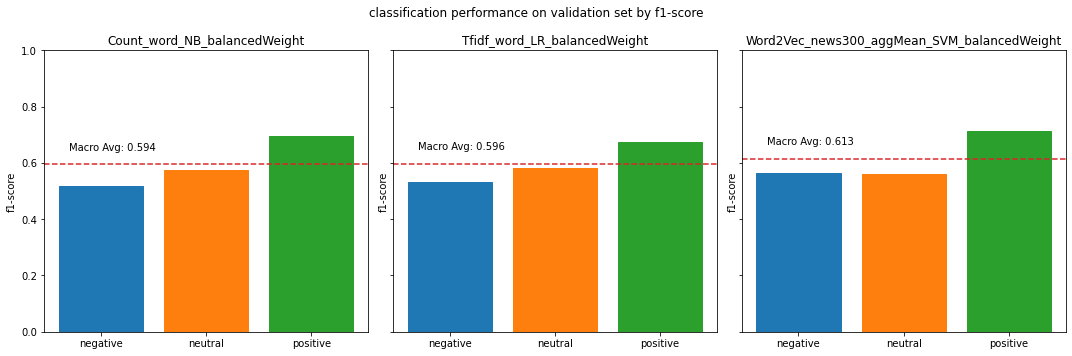

In [74]:
plot_score(select_models,'f1-score')


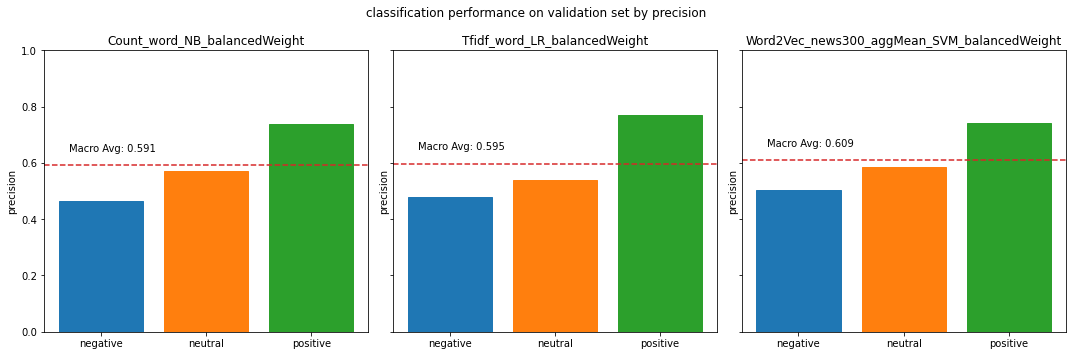

In [75]:
plot_score(select_models,'precision')


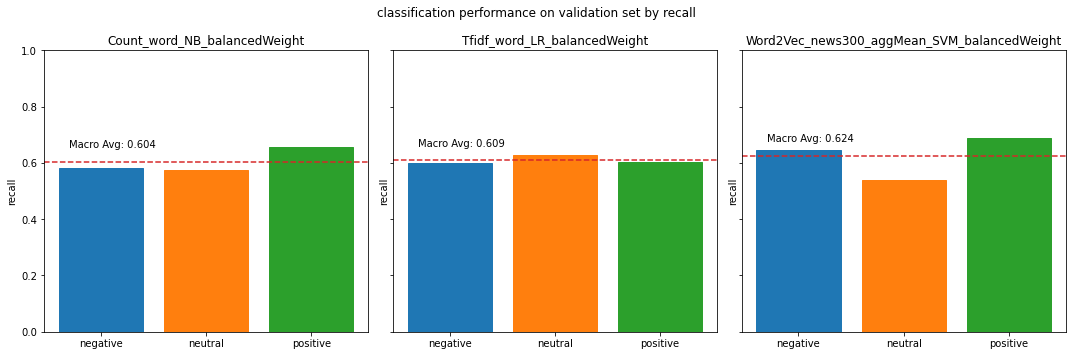

In [76]:
plot_score(select_models,'recall')


In [87]:
# Save prediction outputs from selected models to dataset for ensemble model

for v, m in zip(select_vectorizers, select_models):
    with open('models/'+v,'rb') as f:
        vectorizer = pickle.load(f)
    with open('models/'+m+'.pickle','rb') as f:
        classifier = pickle.load(f)
    
    x_train_vect = vectorizer.transform(x_train)
    df_train['pred_'+m]=classifier.predict(x_train_vect)
    df_train.to_csv('data/Twitter_train.csv',index=False)
    
    x_valid_vect = vectorizer.transform(x_valid)
    df_valid['pred_'+m]=classifier.predict(x_valid_vect)
    df_valid.to_csv('data/Twitter_valid.csv',index=False)
    
    
    # perform prediction on test set
    x_test = df_test['text_clean']
    y_test = df_test['sentiment']
    x_test_vect = vectorizer.transform(x_test)
    df_test['pred_'+m]=classifier.predict(x_test_vect)
    df_test.to_csv('data/Twitter_test.csv',index=False)
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [92]:
for m in select_models:
    print(f"\nClassification Report for Test Set with {m}:\n", classification_report(df_test['sentiment'], df_test['pred_'+m]))
    print()


Classification Report for Test Set with Count_word_NB_balancedWeight:
               precision    recall  f1-score   support

    negative       0.49      0.62      0.55       403
     neutral       0.55      0.54      0.54       623
    positive       0.71      0.63      0.67       939

    accuracy                           0.60      1965
   macro avg       0.58      0.60      0.59      1965
weighted avg       0.61      0.60      0.60      1965



Classification Report for Test Set with Tfidf_word_LR_balancedWeight:
               precision    recall  f1-score   support

    negative       0.51      0.64      0.57       403
     neutral       0.54      0.61      0.58       623
    positive       0.77      0.62      0.69       939

    accuracy                           0.62      1965
   macro avg       0.61      0.62      0.61      1965
weighted avg       0.65      0.62      0.63      1965



Classification Report for Test Set with Word2Vec_news300_aggMean_SVM_balancedWeight:
      

### Concluding Remarks:
- Selected ML classification models (NB,LR and SVM) predict sentiment classification with a macro average F1 score around 60% on test set.
- Will use these selected models in ensemble model to see if we could improve classification performance.